In [1]:
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt  
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as sp
from scipy.stats import norm, skew 


In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

In [3]:

print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))


train_ID = train['Id']
test_ID = test['Id']


train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)


print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


# 데이터 전처리


- outlier 제거

- 지나치게 큰 이상치를 제거함으로써 안전한 모델을 만들수 있다 다른 이상치가 있을 수 있으나, 테스트 데이터에도 이상치가 있을 수 있으므로, 이상치를 모두 없애기보다는, 일부는 남겨서 더 강건한 모델을 구축할 수 있다. 

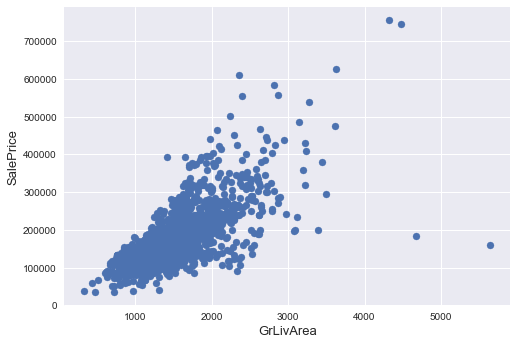

In [4]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

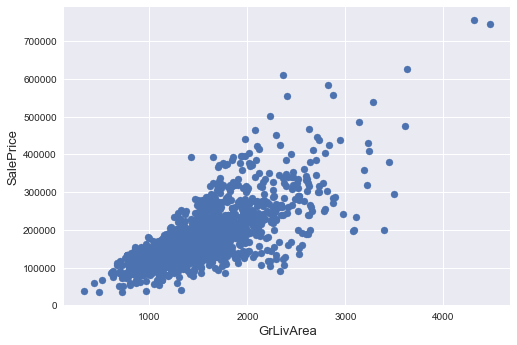

In [5]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)


fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

# 목적 함수
- SalePrice
- regression에서 데이터들은 skewed 되지않고 정규분포에 가까울수록 좋은 결과가 나오므로
- QQ plot을 통해 정규분포인지 확인한다
- 아래에서는 skewed data이므로 정규분포를 따르게 하기위해 여기서는 log-transformation을 해주었다.

C:\Users\POWER USER\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j



 mu = 180932.92 and sigma = 79467.79



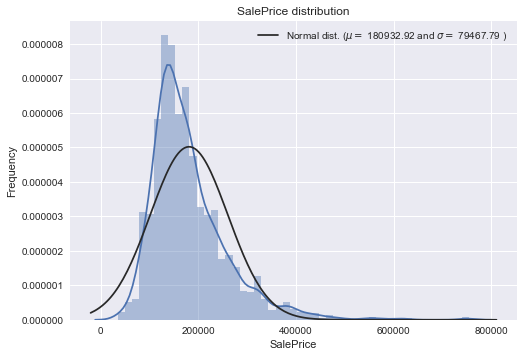

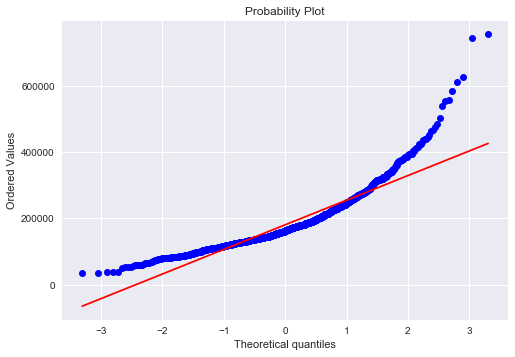

In [6]:
sns.distplot(train['SalePrice'] , fit=norm);

(mu, sigma) = sp.norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


fig = plt.figure()
res = sp.probplot(train['SalePrice'], plot=plt)
plt.show()

C:\Users\POWER USER\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j



 mu = 12.02 and sigma = 0.40



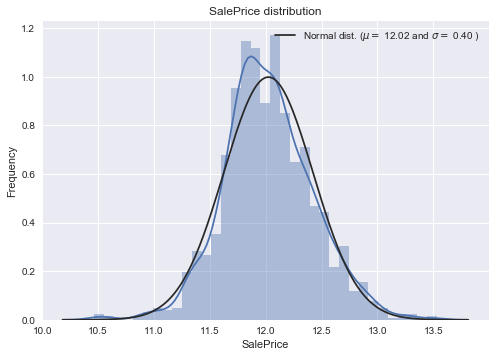

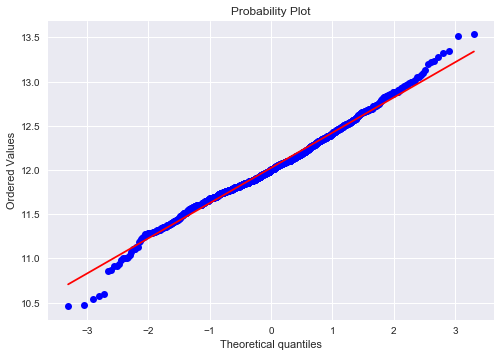

In [7]:

train["SalePrice"] = np.log(train["SalePrice"])


sns.distplot(train['SalePrice'] , fit=norm);

(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')


fig = plt.figure()
res = sp.probplot(train['SalePrice'], plot=plt)
plt.show()

In [8]:
ntrain = train.shape[0]
ntest = test.shape[0]

y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


In [9]:
all_data.tail()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
2912,546,546,0,NaN,3,Twnhs,TA,No,0.0,0.0,...,WD,0,Pave,5,546.0,AllPub,0,1970,1970,2006
2913,546,546,0,NaN,3,TwnhsE,TA,No,252.0,0.0,...,WD,0,Pave,6,546.0,AllPub,0,1970,1970,2006
2914,1224,0,0,NaN,4,1Fam,TA,No,1224.0,0.0,...,WD,0,Pave,7,1224.0,AllPub,474,1960,1996,2006
2915,970,0,0,NaN,3,1Fam,TA,Av,337.0,0.0,...,WD,0,Pave,6,912.0,AllPub,80,1992,1992,2006
2916,996,1004,0,NaN,3,1Fam,TA,Av,758.0,0.0,...,WD,0,Pave,9,996.0,AllPub,190,1993,1994,2006


# Missing Data
- 데이터셋에는 NA로 된 데이터가 많았다. 
- 각 feature별로 isnull()함수를 통해 비어있는 칸을 구하고 그 비율을 구한다.  


In [10]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na[all_data_na > 0].sort_values(ascending = False)
all_data_na

PoolQC          99.691464
MiscFeature     96.400411
Alley           93.212204
Fence           80.425094
FireplaceQu     48.680151
LotFrontage     16.660953
GarageQual       5.450806
GarageCond       5.450806
GarageFinish     5.450806
GarageYrBlt      5.450806
GarageType       5.382242
BsmtExposure     2.811107
BsmtCond         2.811107
BsmtQual         2.776826
BsmtFinType2     2.742544
BsmtFinType1     2.708262
MasVnrType       0.822763
MasVnrArea       0.788481
MSZoning         0.137127
BsmtFullBath     0.068564
BsmtHalfBath     0.068564
Utilities        0.068564
Functional       0.068564
Electrical       0.034282
BsmtUnfSF        0.034282
Exterior1st      0.034282
Exterior2nd      0.034282
TotalBsmtSF      0.034282
GarageArea       0.034282
GarageCars       0.034282
BsmtFinSF2       0.034282
BsmtFinSF1       0.034282
KitchenQual      0.034282
SaleType         0.034282
dtype: float64

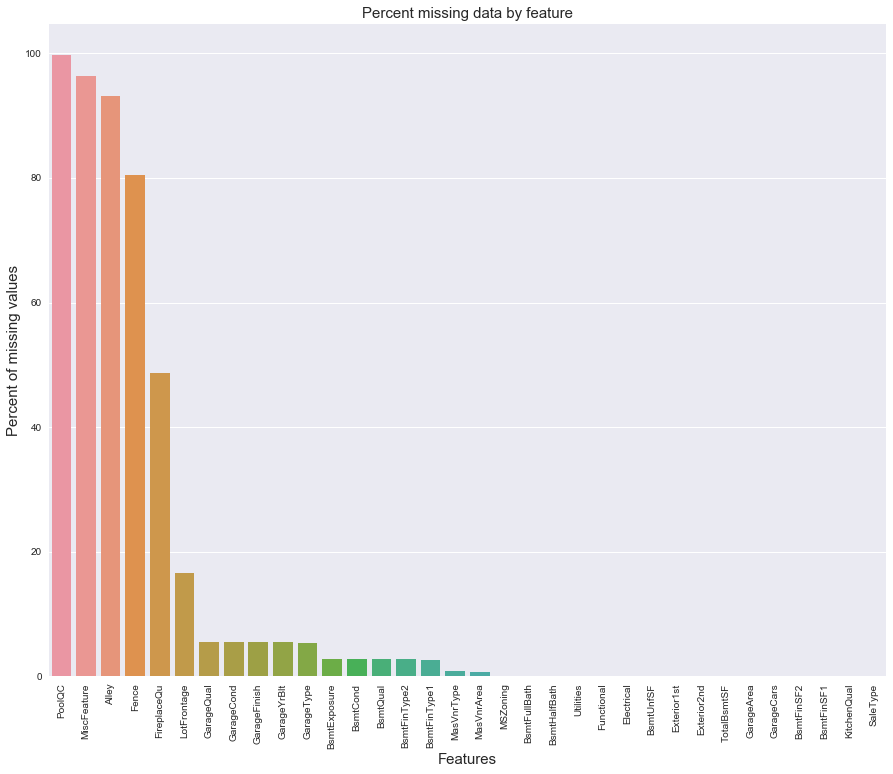

In [11]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

# 상관분석

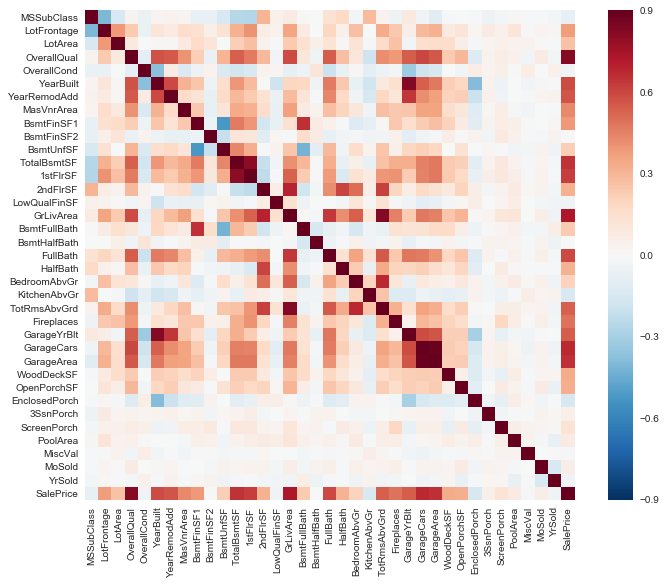

In [12]:

corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [13]:
all_data["BsmtFinType2"]

0       Unf
1       Unf
2       Unf
3       Unf
4       Unf
5       Unf
6       Unf
7       BLQ
8       Unf
9       Unf
10      Unf
11      Unf
12      Unf
13      Unf
14      Unf
15      Unf
16      Unf
17      NaN
18      Unf
19      Unf
20      Unf
21      Unf
22      Unf
23      Unf
24      ALQ
25      Unf
26      Rec
27      Unf
28      Unf
29      Unf
       ... 
2887    Unf
2888    Unf
2889    NaN
2890    Unf
2891    Unf
2892    Unf
2893    Unf
2894    Unf
2895    Unf
2896    Unf
2897    Unf
2898    Unf
2899    BLQ
2900    Unf
2901    Unf
2902    NaN
2903    Unf
2904    Unf
2905    Unf
2906    Unf
2907    Unf
2908    Unf
2909    BLQ
2910    Unf
2911    Unf
2912    Unf
2913    Unf
2914    Unf
2915    Unf
2916    Unf
Name: BsmtFinType2, dtype: object

# Missing data 채우기

- 데이터가 수치형 데이터(numeric data)와 범주형 데이터(categorical data)가 섞여있으므로 따로 채운다.
- 이를 분석하기 위해서 각 feature들의 의미를 정확히 분석할 필요가 있다.

- 다음은 missing data가 있는 feature들을 모아 Kaggle에서 나온 feature들의 설명을 덧붙인 것이다.

- PoolQC         : Pool quality (풀장의 질, Nan이면 없는것 : /범주형)
- MiscFeature    : Miscellaneous feature not covered in other categories(기타: None /??)
- Alley          : Type of alley access (근접한 골목 종류 Nan이면 없는것 : /범주형
- Fence          : Fence quality (울타리의 질, Nan이면 없는것 :/ 범주형)
- FireplaceQu    : Fireplace quality (난로의 질: Nan이면 없는것 :/ 범주형)
- LotFrontage    : Linear feet of street connected to property (집의 너비 Nan은 임의로 같은 이웃을 가진 index들의 평균값으로 설정 : /수치형)
- GarageYrBlt    : Year garage was built (차고 지어진 년수 Nan이면 없는것 : 0 /수치형)
- GarageType     : Garage location (차고 종류 Nan이면 없는것 : None /범주형)
- GarageQual     : Garage quality  (차고 질 Nan이면 없는것 : None /범주형)
- GarageFinish   : Interior finish of the garage (차고 마감 Nan이면 없는것 : None /범주형)
- GarageCond     : General condition of the basement (차고 상태 Nan이면 없는것 : None/ 범주형)
- BsmtFinType2   : Quality of second finished area (if present) (지하실 없으면 Nan : None/범주형)
- BsmtExposure   : Walkout or garden level basement walls (지하실 없으면 Nan : None/범주형)
- BsmtQual       : Height of the basement (지하실의 높이 지하실 없으면 Nan : None/범주형)
- BsmtFinType1   : Quality of basement finished area (지하실 없으면 Nan: None/범주형)
- BsmtCond       : General condition of the basement (지하실 상태 지하실 없으면 Nan:None /범주형)
- MasVnrArea     : Masonry veneer area in square feet (벽돌 지역 없으면 Nan: 0/수치형
- MasVnrType     : Masonry veneer type (벽돌 지역 없으면 Nan: 0/수치형)
- Electrical     : Electrical system (전기 없으면 Nan:none/범주형)

## None으로 바꿔야할 Features
- 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageQual', 'GarageFinish', 'GarageCond','BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtFinType1', 'BsmtCond', 'MasVnrType', 'Electrical'

In [14]:
to_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
           'GarageType', 'GarageQual', 'GarageFinish', 'GarageCond',
           'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtFinType1',
           'BsmtCond', 'MasVnrType', 'Electrical']
all_data[to_none] = all_data[to_none].fillna("None")

## 0으로 바꿔야할 Features
- 'MasVnrArea',' GarageYrBlt'

- LotFrontage는 누락된 것으로 보이므로 이웃들의 평균값으로 가정한다. 

In [15]:
to_zero = ['MasVnrArea','GarageYrBlt']
all_data[to_zero] = all_data[to_zero].fillna(0)


In [16]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.mean()))

In [17]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

,Missing Ratio
MSZoning,0.137127
Utilities,0.068564
Functional,0.068564
BsmtHalfBath,0.068564
BsmtFullBath,0.068564
TotalBsmtSF,0.034282
SaleType,0.034282
KitchenQual,0.034282
GarageCars,0.034282
GarageArea,0.034282


In [18]:
categorical = []
for i in all_data.columns:
    if i in numeric_feats:
        continue
    else:
        categorical.append(i)
        
categorical = np.array(categorical)
categorical.shape

NameError: name 'numeric_feats' is not defined

In [ ]:
category_df = all_data[categorical]

In [ ]:
reduce_columns = category_df.sum(axis = 0)[category_df.sum(axis = 0) < 50].index

In [ ]:
reduce_data = all_data.drop(reduce_columns, axis = 1)
reduce_data.shape

## 수치이지만 실제로는 범주형 데이터인 것들
- 건물 클래스는 범주형이다.(MSSubClass)
- 전체적인 건물상태 -> 범주형 (OverallCond)
- 팔린 년도, 월은 범주형 (참고: 시계열 데이터는 범주형도 수치형도 아니고, 분석 목적에 따라 변할 수 있다. 예를 들어 시간에 따라 점차적으로 수치가 변화한다면 수치데이터, 이와같이 특정한 년, 월을 기준으로 한다면 범주형 데이터로 분석한다. (YrSold, MoSold)

In [19]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)



all_data['OverallCond'] = all_data['OverallCond'].astype(str)



all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [20]:
len(all_data.columns)

79

In [21]:
list1 = []
for i in range(len(all_data.columns)):
    if type(all_data.iloc[1, :][i]) == str:
        list1.append(True)
    else:
        list1.append(False)
all_data.columns[list1]

Index(['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd',
       'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC',
       'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig',
       'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature',
       'MoSold', 'Neighborhood', 'OverallCond', 'PavedDrive', 'PoolQC',
       'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'Street',
       'Utilities', 'YrSold'],
      dtype='object')

In [22]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
print(len(numeric_feats))

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness

32

Skew in numerical features: 



,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
KitchenAbvGr,4.300550
BsmtFinSF2,4.143683
EnclosedPorch,4.002344
ScreenPorch,3.945101
BsmtHalfBath,3.928397


In [23]:
skewness = skewness[abs(skewness) > 0.75].dropna()

transfor = skewness.index

all_data[transfor] = sp.boxcox(1+all_data[transfor], 0.3)


C:\Users\POWER USER\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1034: RuntimeWarning: invalid value encountered in less_equal
  if any(x <= 0):


In [24]:
all_data = pd.get_dummies(all_data)

In [25]:
train = all_data[:ntrain]
test = all_data[ntrain:]
print(train.shape)
print(test.shape)


(1458, 340)
(1459, 340)


# 회귀 모델 구축

In [26]:
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression #라소, 엘라스틱넷, 회귀분석
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor #랜덤포레스트, 그래디언트부스
from sklearn.kernel_ridge import KernelRidge #커널 트릭 + 릿지
from sklearn.pipeline import make_pipeline #scaling과 모델 한꺼번에 쓰는 함수
from sklearn.preprocessing import RobustScaler #RobustScaler quantile을 통해서 scaling(outlier 제거기능)
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone #모델 합칠때 사용하는 함수들
from sklearn.model_selection import KFold, cross_val_score, train_test_split #교차검증 import
from sklearn.metrics import mean_squared_error #평가방식 MSE

참조: http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [27]:
a = np.zeros([len(train), 1])

for x, y in KFold(n_splits = 5, shuffle=True, random_state=36).split(train.values, y_train):
    print(x.shape, y.shape)
    a[y] = 1
    print(a[a ==1].shape)
    
    

(1166,) (292,)
(292,)
(1166,) (292,)
(584,)
(1166,) (292,)
(876,)
(1167,) (291,)
(1167,)
(1167,) (291,)
(1458,)


In [28]:
KFold(n_splits = 5, shuffle=True, random_state=36).get_n_splits(train.values)


5

In [29]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = n_folds))
    print(cross_val_score(model, train.values, y_train, cv=n_folds))
    return(rmse)

In [30]:
linear = make_pipeline(RobustScaler(), LinearRegression())

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, max_iter=10000, random_state=42))
#lasso =  Lasso(alpha =0.0005, max_iter=10000, random_state=1)

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, max_iter=10000, l1_ratio=.8, random_state=3))

KRR = make_pipeline(RobustScaler(), KernelRidge(alpha=0.5, kernel='polynomial', degree=2, coef0=3.5))
#KRR = KernelRidge(alpha=0.6, kernel='linear', degree=2, coef0=3.5)

score = rmsle_cv(linear)
print('linear : {:.4f}({:.4f})\n'.format(score.mean(), score.std()))

score = rmsle_cv(lasso)

print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


[ 0.89751782  0.9082559   0.86673616  0.91050521  0.90786236]
linear : 0.1270(0.0123)

[ 0.926917    0.93261261  0.91312153  0.92498582  0.91877114]

Lasso score: 0.1103 (0.0060)

[ 0.92685365  0.93283174  0.91270238  0.92550983  0.91890749]
ElasticNet score: 0.1103 (0.0062)

[ 0.91304519  0.92774547  0.91241518  0.92334022  0.91541305]
Kernel Ridge score: 0.1138 (0.0050)



In [31]:

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.03,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

RF = RandomForestRegressor(n_estimators=3000, max_depth=4, max_features='sqrt', min_samples_leaf=15, random_state = 5)


score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(RF)
print('RandomForest score : {:.4f}({:.4f})'.format(score.mean(), score.std()))

[ 0.91717448  0.91113571  0.90635364  0.91722089  0.91512391]
Gradient Boosting score: 0.1174 (0.0072)

[ 0.78064675  0.75355898  0.74178615  0.74940349  0.75388611]
RandomForest score : 0.1971(0.0112)


In [32]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        self.models_ = [clone(x) for x in self.models]
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [33]:
averaged_models = AveragingModels(models = (ENet, lasso, KRR,  GBoost))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[ 0.9278864   0.93271036  0.91701944  0.93011033  0.92263068]
 Averaged base models score: 0.1084 (0.0059)



In [38]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                print(type(train_idx))
                print(type(X))
                print(X[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [35]:
class AverageStackingModel(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models, metamodel, nfold = 5):
        self.models = models
        self.models_ = [list() for _ in range(len(self.models))]
        self.meta = metamodel
        self.nfold = nfold
    def fit(self, X, y):
        # 데이터 나눌 준비
        kf = KFold(self.nfold, shuffle = True, random_state = 42)
        # 메타모델을 위한 데이터셋 구축
        meta_feature = np.zeros(shape = (len(X), len(self.models)))
        for i, model in enumerate(self.models):
            for train_idx, holdout_idx in kf.split(X, y):
)
                instance_model = clone(model)
                self.models_[i].append(instance_model)
                instance_model.fit(X[train_idx], y[train_idx])
                meta_feature[holdout_idx, i] = instance_model.predict(X[holdout_idx])
        self.meta.fit(first_prediction, y)
        return self
    
    def predict(self, X):
        meta_feature = np.column_stack(
            [np.column_stack([model.predict(X) for model in models]).mean(axis = 1) for models in self.models_])
        return self.meta.predict(meta_feature)
                

In [39]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, lasso, KRR, GBoost),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

NameError: name 'train_idx' is not defined

In [ ]:
averaged_model = AveragingModels(models = (ENet, lasso, KRR,  GBoost))
averaged_model.fit(train.values, y_train)
predict = averaged_model.predict(test)
predict = np.expm1(predict)
predict

In [ ]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
stacked_pred

In [ ]:
averaged_model = AveragingModels(models = (ENet, lasso, KRR,  GBoost))
averaged_model.fit(train.values, y_train)
predict = averaged_model.predict(test)
predict = np.expm1(predict)
predict

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = stacked_pred
sub.to_csv('submissions.csv',index=False)

In [ ]:
import xgboost as xgb
import lightgbm as lgb

In [ ]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

In [ ]:
model_xgb.fit(train, y_train)

xgb_pred = np.expm1(model_xgb.predict(test))


model_lgb.fit(train, y_train)

lgb_pred = np.expm1(model_lgb.predict(test.values))


In [ ]:
ensemble = stacked_pred*0.50 + xgb_pred*0.25 + lgb_pred*0.25

In [ ]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submissions.csv',index=False)